# Checking the performance of `pympc` topocentric corrections

Here we use a large search cone to find Minor Planet Center (MPC) positions of minor bodies -
retrieving both their geocentric and topocentric positions.

We compare this search cone to results from `pympc` in order to see how well the topocentric
corrections are working.

In addition, the epoch chosen for this comparison (Mar 04 2022) is significantly different from
xephem database epoch that was used (Jan 20 2022). This allows us to additionally compare the
degradation of the positional accuracies with respect to the ideal case shown in
`position_accuracy.ipynb`.


>
> **TL;DR**
The topocentric corrections essentially recover the positional accuracy with MPC when
comparing geocentric positions.
There is only a factor ~2 degradation in the accuracy of the positions compared to the idealised
epoch case.
## Setup

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
from astropy.time import Time

import pympc

### Update catalogue (done on 2023-07-25)

In [2]:
# pympc.update_catalogue(cat_dir=".")

'/home/jdl/git/repos/pympc/notebooks/mpcorb_xephem.csv'

### Load Minor Planet Center's results

A 300-arcminute centred on ra=dec=0 was search via the [MPChecker](https://www.minorplanetcenter.net/cgi-bin/checkmp.cgi)
service on, with date 2023-07-25.00. After some minor manually cleanup of the catalogues, they have been stored as `.txt` files in this directory.

First retreive the geocentric results (Observatory Code 500):

In [3]:
mpc_geo_tbl = Table.read("minor_planet_center_results_geo.txt",
                         format="ascii.fixed_width",
                         col_starts=(9,25, 36, 47),
                         col_ends=(24,34, 45, 50)
                         )
mpc_geo_tbl["mpc_geo_coords"] = SkyCoord(ra=mpc_geo_tbl["R.A."], dec=mpc_geo_tbl["Decl."], unit=(u.hourangle, u.deg))
# Need to have same column name as pympc table to join tables
mpc_geo_tbl.rename_column("designation", "name")
# Remove any with any masked values
mpc_geo_tbl.remove_rows(np.where([c.data for c in mpc_geo_tbl.mask.itercols()])[-1])

And then topocentric results for a representative observatory, here taken to be La Palma (Observatory Code 950)

In [4]:
mpc_topo_tbl = Table.read("minor_planet_center_results_topo.txt",
                         format="ascii.fixed_width",
                         col_starts=(9,25, 36, 47),
                         col_ends=(24,34, 45, 50)
                         )
mpc_topo_tbl["mpc_topo_coords"] = SkyCoord(ra=mpc_topo_tbl["R.A."], dec=mpc_topo_tbl["Decl."], unit=(u.hourangle, u.deg))
# Need to have same column name as pympc table to join tables
mpc_topo_tbl.rename_column("designation", "name")
# Remove any with any masked values
mpc_topo_tbl.remove_rows(np.where([c.data for c in mpc_topo_tbl.mask.itercols()])[-1])

### Perform the same search with `pympc`

Define the search parameters used in the MPC cone search:

In [5]:
epoch = Time("2022-03-04").mjd
search_radius = 300 * u.arcmin
ra = 0 * u.deg
dec = 0 * u.deg
max_mag = 24

Run the `pympc` searches:

In [6]:
# Geocentric
obs_code = 500
pympc_geo_tbl = pympc.minor_planet_check(ra, dec, epoch, search_radius, max_mag=max_mag, observatory=obs_code)
pympc_geo_tbl["pympc_geo_coords"] = SkyCoord(ra=pympc_geo_tbl["ra"], dec=pympc_geo_tbl["dec"], unit=(u.deg, u.deg))
del pympc_geo_tbl["xephem_str"]

#Topocentric
obs_code = 950
pympc_topo_tbl = pympc.minor_planet_check(ra, dec, epoch, search_radius, max_mag=max_mag, observatory=obs_code)
pympc_topo_tbl["pympc_topo_coords"] = SkyCoord(ra=pympc_topo_tbl["ra"], dec=pympc_topo_tbl["dec"], unit=(u.deg, u.deg))
del pympc_topo_tbl["xephem_str"]

### Compare the results

In [7]:
# Join all tables so we can easily access the coordinates from each
joined_tbl = join(pympc_geo_tbl, pympc_topo_tbl, keys="name")
joined_tbl = join(joined_tbl, mpc_geo_tbl, keys="name")
joined_tbl = join(joined_tbl, mpc_topo_tbl, keys="name")

99.9% of the MPC(geo) results are within 4 arcsec of pympc(geo) positions
2.35 arcsec is the median separation
37.8% of the MPC(topo) results are within 4 arcsec of pympc(geo) positions
4.16 arcsec is the median separation
99.9% of the MPC(topo) results are within 4 arcsec of pympc(topo) positions
2.37 arcsec is the median separation


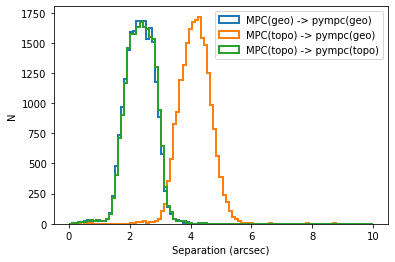

In [8]:
for cmp in [("geo", "geo"), ("topo", "geo"), ("topo", "topo")]:
    sep = joined_tbl[f"mpc_{cmp[0]}_coords"].separation(joined_tbl[f"pympc_{cmp[1]}_coords"]).to(u.arcsec)
    _ = plt.hist(sep.value, bins=np.linspace(0, 10, 100), histtype="step", lw=2, label=f"MPC({cmp[0]}) -> pympc({cmp[1]})")
    print(f"{100*np.sum(sep < 4 * u.arcsec)/len(sep):.1f}% of the MPC({cmp[0]}) results are within 4 arcsec of pympc({cmp[1]}) positions")
    print(f"{np.median(sep):.2f} is the median separation")
plt.legend()
plt.xlabel("Separation (arcsec)")
plt.ylabel("N")
plt.savefig("geo_topo_comparison.png")

The topocentric results essentially recover the performance of the geocentric results, indicating
the corrections are working as intended,

Additionally, the median separation, is only a factor 2 worse than that of the idealised epoch case
presented in the other notebook. Accuracy remains comparable to the PSF size of ground-based telescopes.